# Extract Simons Observatory instrument parameters

In order to be independent of `sotodlib` and track versions of the instrument model parameters more easily, we extract them to a file included in this repository.

The versioning will be YYYY.MM

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sotodlib.sim_hardware as hardware

hw = hardware.sim_nominal()

In [4]:
import sotodlib

In [5]:
sotodlib.__version__

'0.4.0+1146.g8e71b1b'

In [6]:
fwhm_arcmin = {"SA" : hw.data["telescopes"]["SAT1"]["fwhm"],
"LA":hw.data["telescopes"]["LAT"]["fwhm"]}

In [7]:
from pathlib import Path

In [8]:
from collections import OrderedDict
from astropy import units as u
from astropy.table import QTable

In [9]:
channels = []
for band_label, band_properties in hw.data["bands"].items():
    telescope = band_label[:3]
    print(band_label)
    ch = OrderedDict()
    ch["telescope"] = telescope
    ch["band"] = band_label
    ch["fwhm"] = fwhm_arcmin[telescope[:2]][band_label] * u.arcmin
    properties = hw.data["bands"][band_label]
    for freq_type in ["center", "low", "high"]:
        ch[freq_type + "_frequency"] = band_properties[freq_type] *u.GHz
    channels.append(ch)

LAT_f030
LAT_f040
LAT_f090
LAT_f150
LAT_f230
LAT_f290
SAT_f030
SAT_f040
SAT_f090
SAT_f150
SAT_f230
SAT_f290


## Read CSV of SO resolution and add to instrument model

In [10]:
from astropy.table import Table

In [11]:
so_default_resol = Table.read("so_default_resolution.csv")

In [12]:
so_default_resol.columns

<TableColumns names=('channel','fwhm','Nside','CAR_resol')>

In [13]:
so_default_resol.add_index("channel")

In [14]:
for ch in channels:
    ch_resol = so_default_resol.loc[ch["band"]]
    ch["nside"] = ch_resol["Nside"]
    ch["car_resol"] = ch_resol["CAR_resol"] * u.arcmin

## Add reference to bandpasses

In [15]:
for ch in channels:
    freq = ch["band"].split("_")[-1]
    ch["bandpass_file"] = f"bandpass_{freq}.tbl"

## Bandpasses

Revision `b065fa3854b9a0f36bc9957bb94ec1f9481a5f2a` of https://github.com/simonsobs/instrument_model/

In [16]:
ls ../../../instrument_model/instrument_hardware/modeled_bandpasses/UHF

UHF_wOMT_LAT_beam.txt  UHF_wOMT_SAT_beam.txt  UHF_wOMT.txt


In [17]:
bandpass_files = [
    "../../../instrument_model/instrument_hardware/modeled_bandpasses/LF/LF_skinnyfatter.txt",
    "../../../instrument_model/instrument_hardware/modeled_bandpasses/MF/MF_wOMT_wLPF_v1.txt",
    "../../../instrument_model/instrument_hardware/modeled_bandpasses/UHF/UHF_wOMT.txt",
]

30
40
90
150
220
280


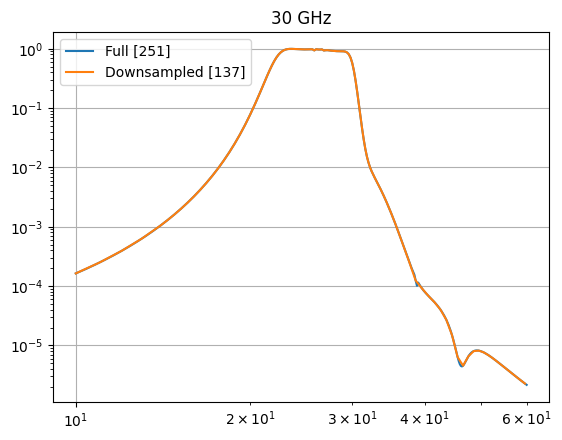

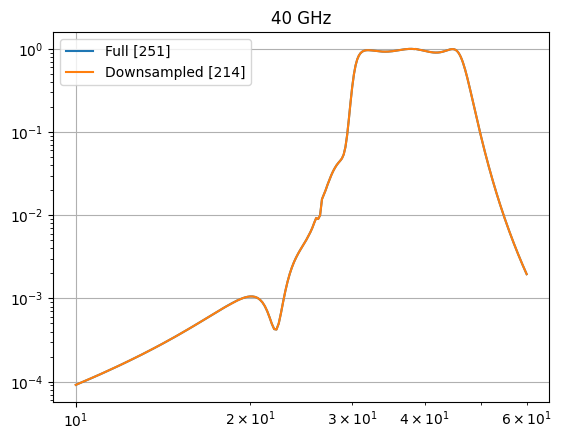

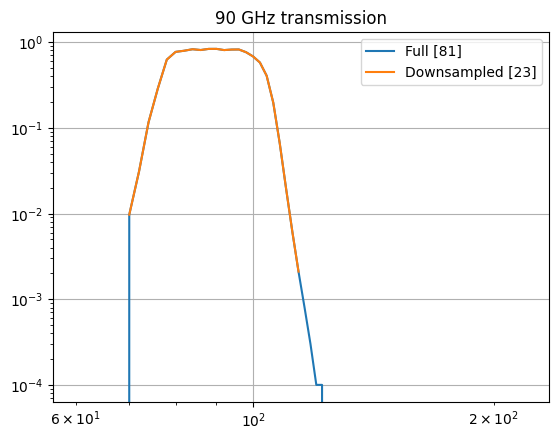

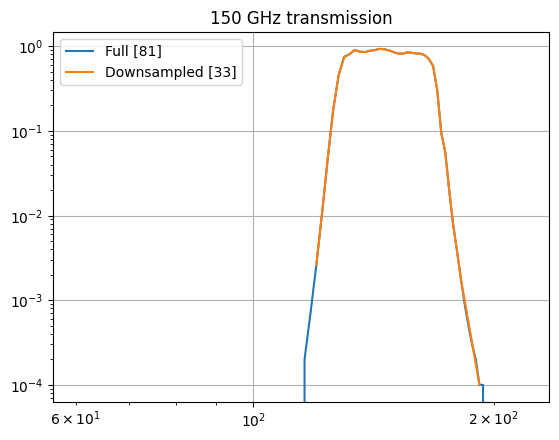

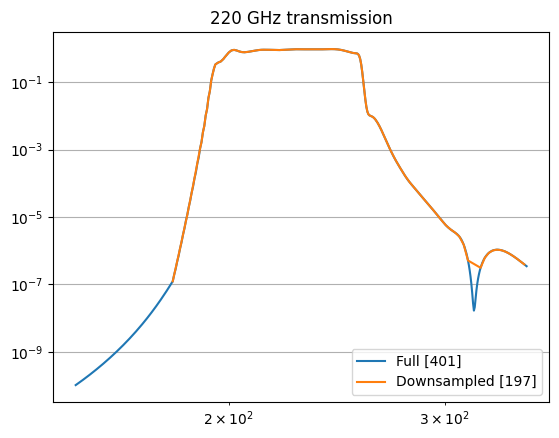

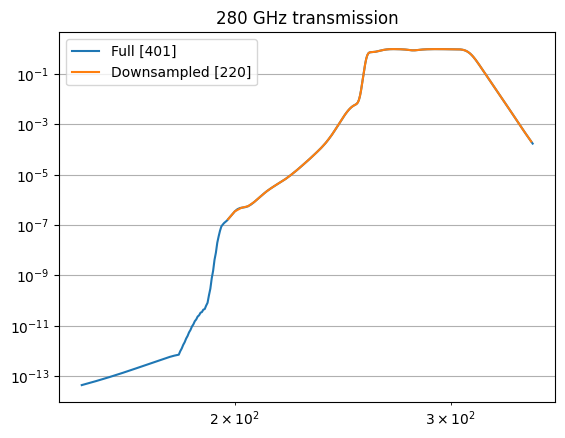

In [18]:
from astropy.io import ascii

for f in bandpass_files:
    modeled_bandpasses = ascii.read(f)
    for band in modeled_bandpasses.keys()[1:]:
        freq = int(band.split()[0])
        print(freq)
        if freq == 220:
            freq = 230
        if freq == 280:
            freq = 290
        freq_label = "Freq" if freq < 50 else "Frequency (GHz)"
        if len(modeled_bandpasses) > 50:
            plt.figure()
            plt.title(band)
            plt.plot(modeled_bandpasses[freq_label], modeled_bandpasses[band], label=f"Full [{len(modeled_bandpasses)}]")
            above_thres, = np.where(modeled_bandpasses[band] /modeled_bandpasses[band].max() > 1e-3)
            downsample = 5
            good = np.concatenate([np.arange(0, above_thres[0], downsample), np.arange( above_thres[0], above_thres[-1]), np.arange(above_thres[-1], len(modeled_bandpasses), downsample)])
            bandpass_column = modeled_bandpasses[band][good][modeled_bandpasses[band][good] > 1e-7]
            freq_column = modeled_bandpasses[freq_label][good][modeled_bandpasses[band][good] > 1e-7]
            plt.loglog(freq_column, bandpass_column, label=f"Downsampled [{len(bandpass_column)}]")
            plt.legend()
            plt.grid()            
        else:
            freq_column = modeled_bandpasses[freq_label]
            bandpass_column = modeled_bandpasses[band]
        QTable({
        "bandpass_frequency":freq_column*u.GHz,
        "bandpass_weight":bandpass_column
        }).write(f"bandpass_f{freq:03d}.tbl", format="ascii.ipac", overwrite=True)

In [19]:
instrument_parameters = QTable(channels)

In [20]:
ipac_warning = ["Text file in IPAC table format, read with astropy",
    "from astropy.table import QTable",
    "QTable.read('filename.tbl', format='ascii.ipac')"]

In [21]:

instrument_parameters.meta["comments"] = ["sotodlib_version:" + sotodlib.__version__] + ipac_warning

In [22]:
instrument_parameters

telescope,band,fwhm,center_frequency,low_frequency,high_frequency,nside,car_resol,bandpass_file
,,arcmin,GHz,GHz,GHz,,arcmin,
str3,str8,float64,float64,float64,float64,int64,float64,str17
LAT,LAT_f030,7.4,25.7,21.7,29.7,2048,2.0,bandpass_f030.tbl
LAT,LAT_f040,5.1,38.9,30.9,46.9,2048,2.0,bandpass_f040.tbl
LAT,LAT_f090,2.2,92.0,79.0,105.0,8192,0.5,bandpass_f090.tbl
LAT,LAT_f150,1.4,147.5,130.0,165.0,8192,0.5,bandpass_f150.tbl
LAT,LAT_f230,1.0,225.7,196.7,254.7,8192,0.5,bandpass_f230.tbl
LAT,LAT_f290,0.9,285.4,258.4,312.4,8192,0.5,bandpass_f290.tbl
SAT,SAT_f030,91.0,25.7,21.7,29.7,128,12.0,bandpass_f030.tbl
SAT,SAT_f040,63.0,38.9,30.9,46.9,128,12.0,bandpass_f040.tbl


In [23]:
instrument_parameters.write("simonsobs_instrument_parameters_2023.03.tbl", format="ascii.ipac", overwrite=True)